<small><i>This notebook was put together by [Alexander Fridman](http://www.rocketscience.ai) for the Lecture Course. Source and license info is on [GitHub](https://github.com/volhahedranovich/jupyter_lectures).</i></small>

# <div class="alert alert-block alert-info">Image Classification with Convolutional Networks</div>

In [1]:
import os
import shutil

import keras
import keras.backend as K
import numpy as np
import pandas as pd
from keras_applications.inception_v3 import InceptionV3, preprocess_input
from keras.datasets import cifar10, mnist
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

%matplotlib inline

Using TensorFlow backend.


### <div class="alert alert-block alert-success">Datasets</div>

CIFAR10
<img src="img/cifar10.png" alt="cifar10" title="cifar10" />

MNIST
<img src="img/mnist.png" width="350px" height="350px" alt="mnist" title="mnist" />

### <div class="alert alert-block alert-success">Load a dataset</div>

In [2]:
DATASET = 'cifar10'

In [3]:
assert DATASET in {'mnist', 'cifar10'}, 'wrong dataset'

if DATASET == 'mnist':
    n_channels = 1
    dataset_loader = mnist.load_data
    batch_size = 128
elif DATASET == 'cifar10':
    n_channels = 3
    dataset_loader = cifar10.load_data
    batch_size = 32
    

def load_data():
    (x_train, y_train), (x_test, y_test) = dataset_loader()
    num_classes = len(np.unique(y_train))
    _, img_rows, img_cols, *_ = x_train.shape

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], n_channels, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], n_channels, img_rows, img_cols)
        input_shape = (n_channels, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, n_channels)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, n_channels)
        input_shape = (img_rows, img_cols, n_channels)
        
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    return (x_train, y_train), (x_test, y_test), num_classes, input_shape


(x_train, y_train), (x_test, y_test), num_classes, input_shape = load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### <div class="alert alert-block alert-success">Convert class vectors to binary class matrices</div>

In [4]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### <div class="alert alert-block alert-success">Build a model</div>

In [5]:
def cifar10_cnn(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

    return model, opt


def mnist_cnn(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model, 'adadelta'

In [6]:
model, opt = globals()['{}_cnn'.format(DATASET)](input_shape, num_classes)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

### <div class="alert alert-block alert-success">Setup image data generator (data augmentation)</div>

In [7]:
x_train = x_train.astype('float') / 255
x_test = x_test.astype('float') / 255

In [8]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

### <div class="alert alert-block alert-success">Train the model</div>

In [13]:
shutil.rmtree('checkpoints', ignore_errors=True)
os.makedirs('checkpoints')

checkpointer = keras.callbacks.ModelCheckpoint('checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5')

train_steps = len(x_train) // batch_size

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=train_steps,
    epochs=10,
    callbacks=[checkpointer],
    validation_data=(x_test, y_test),
    use_multiprocessing=False,
    workers=2)

Epoch 1/10
1562/1562 [==============================] - 9s 6ms/step - loss: 1.8275 - acc: 0.3294 - val_loss: 1.5488 - val_acc: 0.4452
Epoch 2/10
1562/1562 [==============================] - 9s 6ms/step - loss: 1.5024 - acc: 0.4557 - val_loss: 1.3830 - val_acc: 0.5053
Epoch 3/10
1562/1562 [==============================] - 8s 5ms/step - loss: 1.3612 - acc: 0.5106 - val_loss: 1.2334 - val_acc: 0.5563
Epoch 4/10
1562/1562 [==============================] - 6s 4ms/step - loss: 1.2717 - acc: 0.5464 - val_loss: 1.1587 - val_acc: 0.5894
Epoch 5/10
1562/1562 [==============================] - 7s 5ms/step - loss: 1.1934 - acc: 0.5768 - val_loss: 1.0763 - val_acc: 0.6201
Epoch 6/10
1562/1562 [==============================] - 9s 6ms/step - loss: 1.1317 - acc: 0.6028 - val_loss: 1.0231 - val_acc: 0.6392
Epoch 7/10
1562/1562 [==============================] - 8s 5ms/step - loss: 1.0680 - acc: 0.6233 - val_loss: 0.9739 - val_acc: 0.6576
Epoch 8/10
1562/1562 [==============================] - 8s 5ms

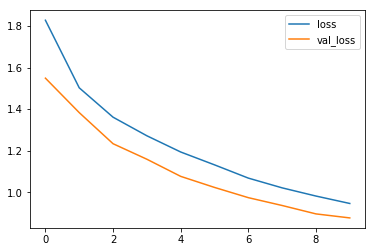

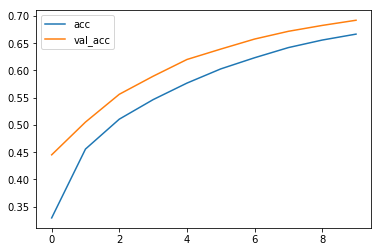

In [14]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot();

### <div class="alert alert-block alert-success">Score the trained model</div>

In [15]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 0s 43us/step
Test loss: 0.8764013585090638
Test accuracy: 0.6921


# <div class="alert alert-block alert-info">Model fine-tuning</div>

*[More info about model fine-tuning with keras](https://keras.io/applications/)*

### <div class="alert alert-block alert-success">Load the data</div>

In [5]:
(x_train, y_train), (x_test, y_test), num_classes, input_shape = load_data()

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### <div class="alert alert-block alert-success">Create the base pre-trained model</div>

In [10]:
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have num_classes classes
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

### <div class="alert alert-block alert-success">Preprocess data in the same way as used while base model was trained</div>

In [6]:
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [7]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    shear_range=0.,  # set range for random shear
    zoom_range=0.,  # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    fill_mode='nearest',  # set mode for filling points outside the input boundaries
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    rescale=None,  # set rescaling factor (applied before any other transformation)
    preprocessing_function=None,  # set function that will be applied on each input
    data_format=None,  # image data format, either "channels_first" or "channels_last"
    validation_split=0.0)  # fraction of images reserved for validation (strictly between 0 and 1)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

### <div class="alert alert-block alert-success">Train only the top layers (which were randomly initialized)</div>

In [ ]:
# freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#     layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train_steps = len(x_train) // batch_size

# train the model on the new data for a few epochs
model.fit(x_train, y_train, batch_size=4)

Epoch 1/1


In [ ]:
# freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

train_steps = len(x_train) // batch_size

# train the model on the new data for a few epochs
model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=2),
    steps_per_epoch=train_steps,
    epochs=2,
    validation_data=(x_test, y_test),
    use_multiprocessing=True,
    workers=2)

Epoch 1/2


> At this point, the top layers are well trained and we can start fine-tuning
  convolutional layers from inception V3. We will freeze the bottom N layers
  and train the remaining top layers.

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=4),
    steps_per_epoch=train_steps,
    epochs=10,
    validation_data=(x_test, y_test),
    use_multiprocessing=True,
    workers=2)

### <div class="alert alert-block alert-success">Score the trained model</div>

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])